In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import csv
import os
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Adherence Trends

* For the days with more than 70% (288 * .7 = 202) records.
* Calculate each individual's trends then average that

In [4]:
def get_days_of_year(date):
  interval = date - datetime(1001, 1, 1)
  num_of_days = interval.days
  return num_of_days

In [5]:
# get some specific days / range

spring = get_days_of_year(datetime(1001, 3, 1))
summer = get_days_of_year(datetime(1001, 6, 1))
fall = get_days_of_year(datetime(1001, 9, 1))
winter = get_days_of_year(datetime(1001, 12, 1))

In [6]:
def date2list(start, periods):
  date1 = pd.Series(pd.date_range(start, periods = periods))
  df = pd.DataFrame(dict(date_given = date1))
  df['Month'] = df['date_given'].dt.month
  df['Day'] = df['date_given'].dt.day
  df = df.drop(['date_given'], axis = 1)
  date_list = df.values.tolist()  # one year's date list
  return date_list

In [7]:
date_list = date2list('2021-1-1 12:00:00', 365)
print(len(date_list), date_list[:5])

365 [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5]]


In [8]:
cgm_day_root = './cgm_count_by_day/'

for filename in os.listdir(cgm_day_root):
  if filename[-4:] == '.csv':
    res_list = [i + [0, 0] for i in date_list]
    df = pd.read_csv(cgm_day_root + filename)

    # days are valid
    df_date = df[['Month','Day']].values.tolist()
    df_valid = df['Valid'].values.tolist()
    for i in range(len(df_date)):
      if df_date[i] != [2, 29]: # do not consider this
        index = date_list.index(df_date[i])
        if df_valid[i] == 1:
          res_list[index][2] += 1

    # duration passed on that date
    start = datetime.strptime(list(df['displayTime'])[0].split(' ')[0], '%Y-%m-%d').date()
    end = datetime.strptime(list(df['displayTime'])[-1].split(' ')[0], '%Y-%m-%d').date()
    passed_lst = date2list(start, (end - start).days + 1)
    for i in passed_lst:
      if i != [2, 29]: # do not consider this
        index = date_list.index(i)
        res_list[index][3] += 1

    df = pd.DataFrame(res_list, columns=['Month', 'Day', 'Valid_nums', 'Passed_nums'])
    df['Valid_ratio'] = df.Valid_nums / df.Passed_nums
    df.to_csv('./individual_adherence_by_day/' + filename, header=['Month', 'Day', 'Valid_nums', 'Passed_nums', 'Ratio'], index = None)
    # break

# Smoothed Seasonal Trends (Fig2A)

In [1]:
ind_trend = './individual_adherence_by_day/'
final_2d_res = [[] for i in range(365)]

for filename in os.listdir(ind_trend):
  if filename[-4:] == '.csv':
    df = pd.read_csv(ind_trend + filename)

    df_list = df.values.tolist()
    # days have records
    for i in range(len(df_list)):
      if df_list[i][3] != 0:
        final_2d_res[i].append(df_list[i][4])

final_res = []
for i in final_2d_res:
  final_res.append(np.mean(i))

# print(final_res)

res_list = [date_list[i] + [final_res[i]] for i in range(len(date_list))]
# print(res_list)

In [ ]:
df = pd.DataFrame(res_list)
df.to_csv('./yearly_adherence_trends.csv', header=['Month', 'Day', 'Valid_ratio'], index = None)

In [2]:
df_valid = pd.read_csv('./yearly_adherence_trends.csv')

ratio = df_valid.Valid_ratio.values.tolist()
# baseline / avg of ratio
avg = np.mean(ratio)
print(avg)

weighted_ratio = [(i - avg) / avg for i in ratio]
print(weighted_ratio)


In [ ]:
smoothed_ratio = pd.DataFrame(weighted_ratio).rolling(7, min_periods=1).mean()

In [ ]:
len(smoothed_ratio)

365

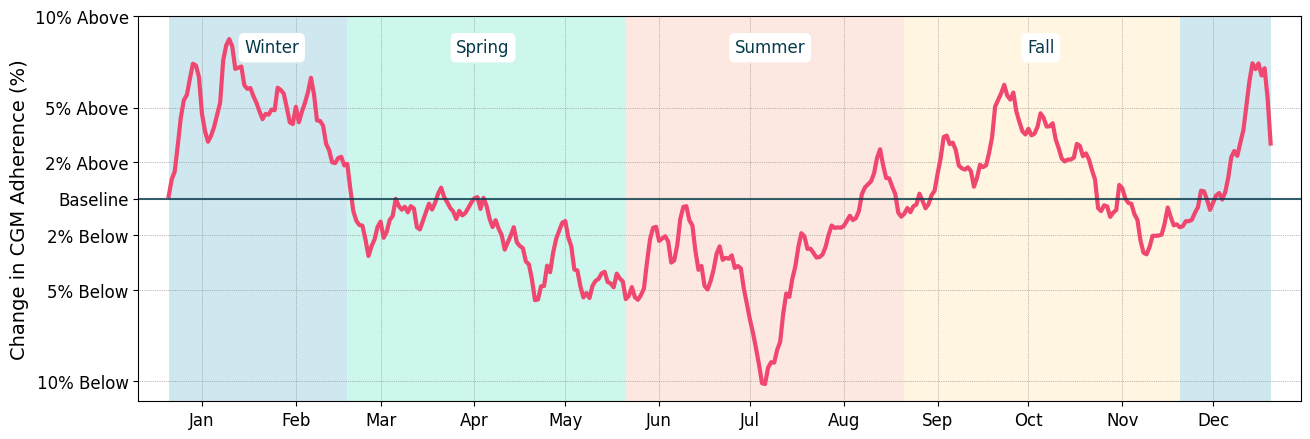

In [ ]:
# color palette: https://coolors.co/palette/ef476f-f78c6b-ffd166-06d6a0-118ab2-073b4c
from matplotlib import dates as mdates
from matplotlib import dates

# plt.figure(figsize=(15,6))
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
# ax.grid(True, linestyle='-.')
plt.plot(smoothed_ratio, label = 'Valid Ratio Trends', color = '#EF476F', linewidth=3.0)
# https://stackoverflow.com/questions/67582913/plotting-time-series-in-matplotlib-with-month-names-ex-january-and-showing-ye
# fmt_month = mdates.MonthLocator(bymonthday=11)
fmt_month = mdates.MonthLocator(bymonthday=12)
ax.xaxis.set_major_locator(fmt_month)
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
plt.xticks(fontsize = 12)
ax.axhline(y = 0, c='#073B4C', linestyle='-', alpha=.8)
ax.set_yticks([-.1, -.05, -.02, 0, .02, .05, .1])
ax.set_yticklabels(['10% Below', '5% Below', '2% Below', 'Baseline', '2% Above', '5% Above', '10% Above'], fontsize = 12)
plt.ylabel('Change in CGM Adherence (%)', fontsize = 14)

# seasons
plt.axvspan(spring, summer, facecolor = '#06D6A0', alpha = .2) # spring
plt.axvspan(summer, fall, facecolor = '#F78C6B', alpha = .2) # summer
plt.axvspan(fall, winter, facecolor = '#FFD166', alpha = .2) # fall

plt.axvspan(winter, 364, facecolor = '#118AB2', alpha = .2) # winter
plt.axvspan(0, spring, facecolor = '#118AB2', alpha = .2)

# label seasons
ax.text((spring + summer)/2-10, 0.08, 'Spring', color = "#073B4C", fontsize = 12,
         bbox=dict(boxstyle="round",
                   ec='white',
                   fc='white',
                   ))
ax.text((summer + fall)/2 - 10,  0.08,  'Summer', color = "#073B4C", fontsize = 12,
         bbox=dict(boxstyle="round",
                   ec='white',
                   fc='white',
                   ))
ax.text((winter + fall)/2 - 5, 0.08, 'Fall', color = "#073B4C", fontsize = 12,
         bbox=dict(boxstyle="round",
                   ec='white',
                   fc='white',
                   ))
ax.text(25, 0.08, 'Winter', color = "#073B4C", fontsize = 12,
         bbox=dict(boxstyle="round",
                   ec='white',
                   fc='white',
                   ))

plt.grid(color='gray', linewidth=0.5, linestyle = ':')
plt.xlim(-10,364 + 10)

plt.savefig("./figures/monthly_adherence/all_subjects_monthly_adh.jpg")
plt.savefig('./final_figures/fig2/seasonal_trends.png',bbox_inches='tight')
plt.savefig('./final_figures/fig2/seasonal_trends.pdf',bbox_inches='tight')


plt.show()

# Monthly Average (Fig2B)

In [3]:
df_valid = pd.read_csv('./yearly_adherence_trends.csv')
df_valid.head()

In [4]:
monthly_adh = []
for i in range(1, 13):
  monthly_adh.append(np.mean(df_valid[df_valid["Month"] == i].Valid_ratio))
monthly_adh

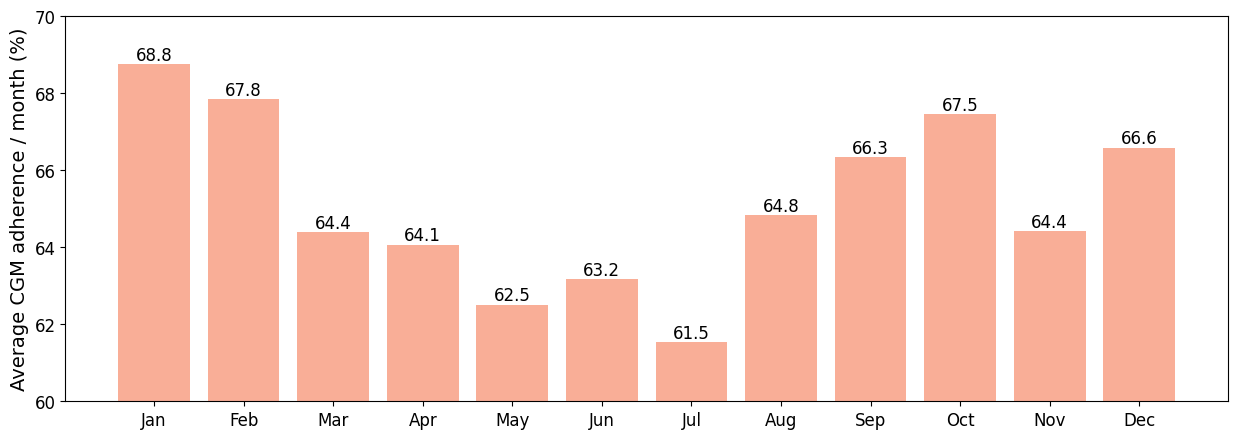

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bar_container = ax.bar(months, np.array(monthly_adh) * 100, color='#F78C6B', alpha = .7)
ax.bar_label(bar_container, fmt='{:,.1f}', fontsize = 12)

ax.set_ylim([60, 70])
ax.set_ylabel('Average CGM adherence / month (%)', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('./figures//monthly_adherence/monthly_avg.png',bbox_inches='tight')
plt.savefig('./final_figures/fig2/monthly_avg_adherence.png',bbox_inches='tight')
plt.savefig('./final_figures/fig2/monthly_avg_adherence.pdf',bbox_inches='tight')

plt.show()